In [76]:
import pandas as pd
import seaborn as sns

##### 0. Hypertension ICD-9 code list 생성

In [92]:
df = pd.read_csv("/data/PUBLIC_DATA/MIMIC-III/D_ICD_DIAGNOSES.csv")
df1 = df[df['LONG_TITLE'].str.contains('hypertension')]
hypertension_list = df1["ICD9_CODE"].to_list()

##### 1. Hypertension 진단 받은 환자 구하기
1. DIAGNOSES_ICD(ICD9을 사용한 병원 입원정보) table을 활용해 환자별 입원 기록에 따른 ICD9 code 합치기
2. hypertension 관련 ICD9 진단 받았는지 데이터만 선별
3. ADMISSIONS(환자의 입원 정보) table을 활용해 동일한 환자가 여러 번 입원한 경우 최초 입원 기록만 남기기

In [238]:
# 입원 기록에 따른 환자별 진단 받은 ICD9 code 합치기
df = pd.read_csv("/data/PUBLIC_DATA/MIMIC-III/DIAGNOSES_ICD.csv")

def add(group):
    return ' '.join(group['ICD9_CODE'].fillna(""))

df1 = df.groupby(['SUBJECT_ID', 'HADM_ID']).apply(add).reset_index(name="ICD9_CODE")

mask = df1['ICD9_CODE'].str.contains('|'.join(hypertension_list), na=False)
df2 = df1[mask]

print("Hypertension 입원 건수: ", len(df2))

# 동일한 환자가 여러 번 입원한 경우 최초 입원 기록만 남기기(22,429명 -> 18,871명)
df = pd.read_csv("/data/PUBLIC_DATA/MIMIC-III/ADMISSIONS.csv")
df3 = df[["HADM_ID", "ADMITTIME", "DISCHTIME", "DEATHTIME"]]
df4 = pd.merge(df2, df3, on="HADM_ID")
df4['ADMITTIME'] = pd.to_datetime(df4['ADMITTIME'])
df4['DISCHTIME'] = pd.to_datetime(df4['DISCHTIME'])
df4['DEATHTIME'] = pd.to_datetime(df4['DEATHTIME'])

df5 = df4.sort_values(by=['SUBJECT_ID', 'ADMITTIME'], ascending=[True, True])
df5 = df5.drop_duplicates(subset=['SUBJECT_ID'], keep='first')
df5.sort_values(by=["SUBJECT_ID"], ascending=True, inplace=True)
print("Hypertension 환자 수(최초 입원): ", len(df5))

Hypertension 입원 건수:  22429
Hypertension 환자 수(최초 입원):  18871


##### 2. 1차 조건 적용(24H 이상, 첫 입원 시점 연령 18세 이상/89세 이하)
1. 24H 이상 머문 환자(18,871명 -> 18,262명)
2. 18세 이상(18,262명 -> 18,237명)
3. 89세 이하(18,237명 -> 17,208명)
-> 첫 입원 시점 연령은 "첫 입원 날짜" - "환자의 생년월일"로 계산

In [239]:
# LOS 추가 후 24H 이상 머문 환자 list만 저장(18,871명 -> 18,262명)
df5["LOS"] = df5["DISCHTIME"] - df5["ADMITTIME"]
over = df5["LOS"] >= "1days"
df6 = df5[over].sort_values(by=["LOS"], ascending=True)
subject_list = df6["SUBJECT_ID"].to_list()
print("LOS가 24H 이상인 환자 수: ", len(subject_list))

LOS가 24H 이상인 환자 수:  18262


In [240]:
# 첫 입원 시점 연령을 구하기 위해 PATIENTS Table에서 DOB 칼럼 가져오기
df = pd.read_csv("/data/PUBLIC_DATA/MIMIC-III/PATIENTS.csv")
df = df[["SUBJECT_ID", "DOB"]]
df['DOB'] = pd.to_datetime(df['DOB']).dt.date
df7 = pd.merge(df6, df, on="SUBJECT_ID")
# df7["ADMITTIME"] = df7["ADMITTIME"].dt.date

# 첫 입원 시점 연령 칼럼 생성
df7["AGE"] = ((df7["ADMITTIME"].dt.date - df7["DOB"])//365).dt.days

[  0  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89 300 301 302 303 304 305 306 307]


/packages/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AGE', ylabel='Density'>

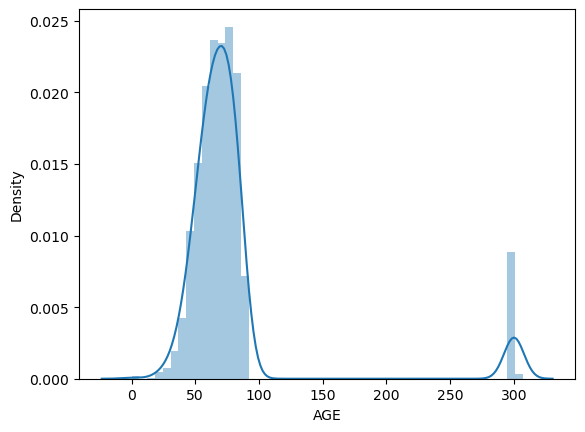

In [241]:
# 개인 정보를 보호하기 위해 날짜 데이터가 슬라이딩되었기 때문에 age가 0 또는 300 이상인 경우가 발생
print(df7["AGE"].sort_values().unique())
sns.distplot(df7["AGE"])

In [242]:
# 18세 이상 환자 선별(18,262명 -> 18,237명)
over = df7["AGE"] >= 18
df8 = df7[over].sort_values(by=["AGE"], ascending=True)
subject_list = df8["SUBJECT_ID"].to_list()
print("18세 이상인 환자 수: ", len(subject_list))

18세 이상인 환자 수:  18237


In [243]:
# 89세 이상 환자 제거(18,262명 -> 17,208명)
over = df8["AGE"] <= 89
df9 = df8[over].sort_values(by=["AGE"], ascending=True)
subject_list = df9["SUBJECT_ID"].to_list()
print("89세 미만인 환자 수: ", len(subject_list))

89세 미만인 환자 수:  17208


##### 3. Hypertension 진단 받은 환자의 30일 이내 사망률 확인

In [244]:
# DOA(Death or Alive): 사망했다면 사망까지 걸린 시간, 생존했다면 NaT 출력
for i in range(len(df9)):
    if df9["DEATHTIME"].iloc[i] != "NaT":
        df9["DOA"] = (df9["DEATHTIME"]-df9["ADMITTIME"])
    else:
        df9["DOA"] = "NaT"

In [299]:
# 사망한 환자 중 가장 오래 생존한 환자는 145일
df9.sort_values(by=["DOA"], ascending=False)["DOA"]

18257   145 days 20:35:00
18253   127 days 00:16:00
18250   123 days 03:04:00
18245   107 days 06:57:00
18242   102 days 17:23:00
               ...       
8579                  NaT
13933                 NaT
2898                  NaT
12552                 NaT
5703                  NaT
Name: DOA, Length: 17208, dtype: timedelta64[ns]

In [309]:
print("Hypertension 진단 받은 환자의 특정 기간 내 사망률")
print("Hypertension 진단 받은 환자 수: ", 17208)
print("-----------------------------------------")
# 30일 이내 사망
less = df9["DOA"] <= "30days"
df10 = df9[less].sort_values(by=["DOA"], ascending=True)
subject_list = df10["SUBJECT_ID"].to_list()
print("30일 이내 사망자 수: ", len(subject_list))
print("30일 이내 사망자 수 비율: ", len(subject_list)/17208*100)
print("-----------------------------------------")

# 60일 이내 사망
less = df9["DOA"] <= "60days"
df11 = df9[less].sort_values(by=["DOA"], ascending=True)
subject_list = df11["SUBJECT_ID"].to_list()
print("60일 이내 사망자 수: ", len(subject_list))
print("60일 이내 사망자 수 비율: ", len(subject_list)/17208*100)
print("-----------------------------------------")

# 90일 이내 사망
less = df9["DOA"] <= "90days"
df12 = df9[less].sort_values(by=["DOA"], ascending=True)
subject_list = df12["SUBJECT_ID"].to_list()
print("90일 이내 사망자 수: ", len(subject_list))
print("90일 이내 사망자 수 비율: ", len(subject_list)/17208*100)
print("-----------------------------------------")

# 120일 이내 사망
less = df9["DOA"] <= "120days"
df13 = df9[less].sort_values(by=["DOA"], ascending=True)
subject_list = df13["SUBJECT_ID"].to_list()
print("120일 이내 사망자 수: ", len(subject_list))
print("120일 이내 사망자 수 비율: ", len(subject_list)/17208*100)
print("-----------------------------------------")

# 150일 이내 사망
less = df9["DOA"] <= "150days"
df14 = df9[less].sort_values(by=["DOA"], ascending=True)
subject_list = df14["SUBJECT_ID"].to_list()
print("150일 이내 사망자 수: ", len(subject_list))
print("150일 이내 사망자 수 비율: ", len(subject_list)/17208*100)
print("-----------------------------------------")

Hypertension 진단 받은 환자의 특정 기간 내 사망률
Hypertension 진단 받은 환자 수:  17208
-----------------------------------------
30일 이내 사망자 수:  1313
30일 이내 사망자 수 비율:  7.6301720130172015
-----------------------------------------
60일 이내 사망자 수:  1398
60일 이내 사망자 수 비율:  8.124128312412832
-----------------------------------------
90일 이내 사망자 수:  1405
90일 이내 사망자 수 비율:  8.164807066480705
-----------------------------------------
120일 이내 사망자 수:  1408
120일 이내 사망자 수 비율:  8.182240818224082
-----------------------------------------
150일 이내 사망자 수:  1411
150일 이내 사망자 수 비율:  8.199674569967456
-----------------------------------------


##### 4. data extraction
1. 환자의 demographic data(인구통계학적 데이터) -> 
2. 환자의 vital signal(활력징후 데이터) -> 
3. 환자의 laboratory value(실험실 데이터) -> LABEVENTS table
4. 생명 유지 장치(?)

##### 5. 2차 조건 적용(missing value)